In [1]:
import distutils.spawn
import os
from matplotlib import rc
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import torch

sns.set(font_scale=1.5)
if distutils.spawn.find_executable('latex'):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)

In [2]:
class mynn(torch.nn.Module):
    def __init__(self, a, u):
        super(mynn, self).__init__()
        self.a = torch.nn.Parameter(a)
        self.u = torch.nn.Parameter(u)
        self.sigma = torch.nn.ReLU()

    def forward(self, x):
        return torch.sum(self.a[..., None] * self.sigma(x - self.u[..., None]), dim = (0, 1))

In [3]:
teacher_u = torch.Tensor([0.3, 0.5, 0.7]).reshape(-1, 1)
teacher_a = torch.Tensor([1.0, -2.0, 3.0]).reshape(-1, 1)
teacher_model = mynn(teacher_a, teacher_u)

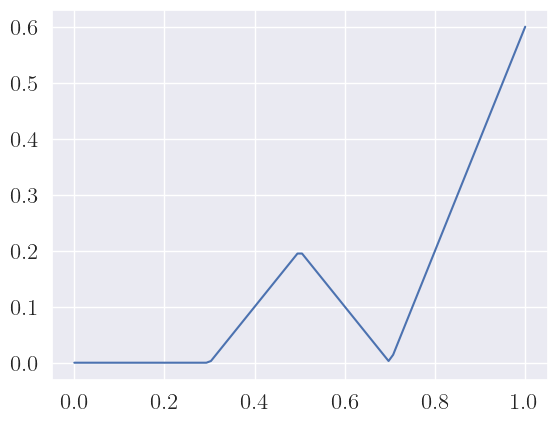

In [4]:
X = torch.linspace(0, 1, 100).reshape(1, -1)
plt.plot(X.detach().numpy().flatten(), teacher_model(X).detach().numpy())
plt.show()

In [5]:
n_repeats = 20
n = 10**3
d = 1

metrics = {'loss': [], 'u': [], 'a': []}
for k in range(n_repeats):
    print(k)
    x = torch.rand(d, n)
    u = torch.rand(10, d)
    # a = torch.zeros(10, d) 
    a = 3 * torch.rand(10, d)
    model = mynn(a, u)
    optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
    
    n_epoch = 5000
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        y_pred = model(x)
        y_target = teacher_model(x)
        criterion = torch.norm(y_pred - y_target) / n
        criterion.backward()
        optimizer.step()
    metrics['loss'].append(float(criterion))
    metrics['u'].append(model.u.detach().numpy())
    metrics['a'].append(model.a.detach().numpy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [6]:
filepath = 'rebuttal/relu-standard.pkl'
with open(filepath, 'wb') as file:
    pickle.dump(metrics, file)

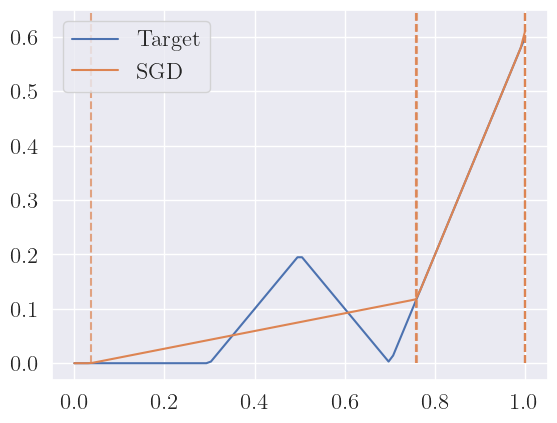

In [7]:
idx = 0
X = torch.linspace(0, 1, 100).reshape(1, -1)
model = mynn(torch.Tensor(metrics['a'][idx]), torch.Tensor(metrics['u'][idx]))
plt.plot(X.detach().numpy().flatten(), teacher_model(X).detach().numpy(), label='Target')
plt.plot(X.detach().numpy().flatten(), model(X).detach().numpy(), label='SGD')
plt.vlines(metrics['u'][idx],
    ymin=0.0,
    ymax=0.7,
    color='C1',
    linestyle='--',
    alpha=0.7)
plt.ylim([-0.03, 0.65])
plt.legend()
plt.savefig('rebuttal/plot_solution_relu_standard.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
metrics_fs = {'loss': [], 'u': [], 'a': []}
for k in range(n_repeats):
    print(k)
    x = torch.rand(d, n)
    u = torch.rand(10, d)
    # a = torch.zeros(10, d) 
    a = 3 * torch.rand(10, d)
    model = mynn(a, u)
    optimizer_a = torch.optim.SGD([model.a], lr=1.0)
    optimizer_u = torch.optim.SGD([model.u], lr=0.01)
    
    n_epoch = 5000
    for epoch in range(n_epoch):
        optimizer_a.zero_grad()
        optimizer_u.zero_grad()
        y_pred = model(x)
        y_target = teacher_model(x)
        criterion = torch.norm(y_pred - y_target) / n
        criterion.backward()
        optimizer_a.step()
        optimizer_u.step()
    metrics_fs['loss'].append(float(criterion))
    metrics_fs['u'].append(model.u.detach().numpy())
    metrics_fs['a'].append(model.a.detach().numpy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [9]:
filepath = 'rebuttal/relu-fs.pkl'
with open(filepath, 'wb') as file:
    pickle.dump(metrics_fs, file)

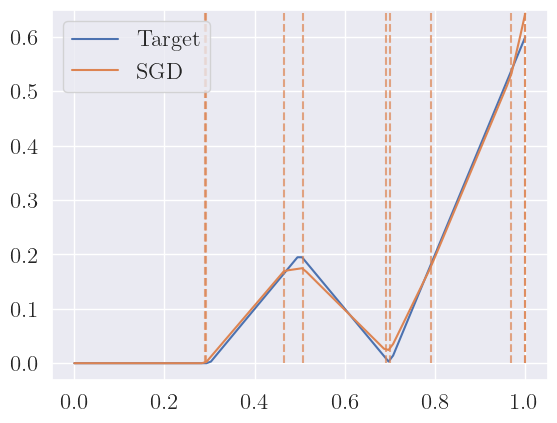

In [12]:
idx = 0
X = torch.linspace(0, 1, 100).reshape(1, -1)
model = mynn(torch.Tensor(metrics_fs['a'][idx]), torch.Tensor(metrics_fs['u'][idx]))
plt.plot(X.detach().numpy().flatten(), teacher_model(X).detach().numpy(), label='Target')
plt.plot(X.detach().numpy().flatten(), model(X).detach().numpy(), label='SGD')
plt.vlines(metrics_fs['u'][idx],
    ymin=0.0,
    ymax=0.7,
    color='C1',
    linestyle='--',
    alpha=0.7)
plt.ylim([-0.03, 0.65])
plt.legend()
plt.savefig('rebuttal/plot_solution_relu_fs.png', dpi=150, bbox_inches='tight')
plt.show()

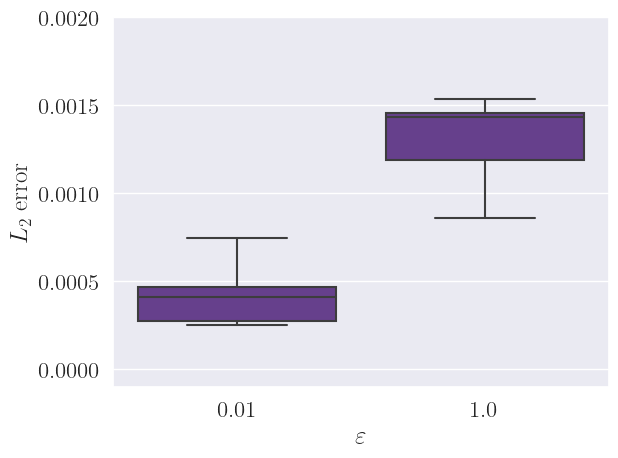

In [11]:
d = {r'$\varepsilon$': [1.0]*20 + [0.01]*20, r'$L_2$ error': metrics['loss'] + metrics_fs['loss']}
df = pd.DataFrame.from_dict(d)
sns.boxplot(data=df, x=r'$\varepsilon$', y=r'$L_2$ error', color='rebeccapurple')
#plt.yscale('log')
plt.ylim([-0.0001, 0.002])
plt.savefig('rebuttal/plot_error_relu.png', dpi=150, bbox_inches='tight')
plt.show()